In [1]:
!pip install --upgrade torch torchaudio

     |████████████████████████████████| 750.6 MB 9.4 kB/s             
     |████████████████████████████████| 2.9 MB 35.8 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.9.1
    Uninstalling torchaudio-0.9.1:
      Successfully uninstalled torchaudio-0.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.5.3 requires torch<1.11,>=1.7.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.9.1 requires torch<1.11.0,>=1.6.0, but you have torch 1.11.0 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import os
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
from pydub import AudioSegment
import glob 
import librosa.display
import pickle
import random

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.functional as F
from torch.nn.modules.activation import ReLU

In [4]:
checkpoint = torch.load('../input/extractor-modell-para/model_checkpoint.pt')

In [5]:
tensor_trx1 = torch.load('../input/train-test-dataset/anchtensor_train.pt')
tensor_trx2 = torch.load('../input/train-test-dataset/positensor_train.pt')
tensor_trxy = torch.load('../input/train-test-dataset/idtensor_train.pt')
tensor_tsx1 = torch.load('../input/train-test-dataset/anchtensor_test.pt')
tensor_tsx2 = torch.load('../input/train-test-dataset/positensor_test.pt')
tensor_tsxy = torch.load('../input/train-test-dataset/idtensor_test.pt')

In [6]:
tensor_trx1.shape

torch.Size([24257, 32000])

In [7]:
batch_size = 16

In [8]:
train_dataset = TensorDataset(tensor_trx1, tensor_trxy, tensor_trx2)
test_dataset = TensorDataset(tensor_tsx1, tensor_tsxy, tensor_tsx2) 
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=True) # create your dataloader
validation_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, drop_last=True) # create your dataloader

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
# class ResidualLayer(nn.Module):
#     """
#     One residual layer inputs:
#     - in_dim : the input dimension
#     - h_dim : the hidden layer dimension
#     - res_h_dim : the hidden dimension of the residual block
#     """

#     def __init__(self, in_dim, res_h_dim):
#         super(ResidualLayer, self).__init__()
#         self.res_block = nn.Sequential(
#             nn.Conv1d(in_dim, res_h_dim, kernel_size=3,
#                       stride=2, padding=1, bias=False),
#             nn.BatchNorm1d(res_h_dim),
#             nn.ReLU(),
#             nn.Conv1d(res_h_dim, in_dim, kernel_size=1,
#                       stride=1, bias=False),
#             nn.BatchNorm1d(in_dim)
#         )
        
#         self.skipconc = nn.Sequential(
#             nn.Conv1d(in_dim, in_dim, kernel_size=1,
#                       stride=2, bias=False),
#             nn.BatchNorm1d(in_dim)
#         )
        
#     def forward(self, x):
#         x = self.skipconc(x) + self.res_block(x)
#         x = F.relu(x)
#         return x

In [11]:
# class ResidualStack(nn.Module):
#     """
#     A stack of residual layers inputs:
#     - in_dim : the input dimension
#     - h_dim : the hidden layer dimension
#     - res_h_dim : the hidden dimension of the residual block
#     - n_res_layers : number of layers to stack
#     """

#     def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
#         super(ResidualStack, self).__init__()
#         self.n_res_layers = n_res_layers
#         self.stack = nn.ModuleList(
#             [ResidualLayer(in_dim, res_h_dim)]*n_res_layers)           #Adding Multiple Residual blocks into the list
#         self.conv = nn.Conv1d(in_dim, h_dim, kernel_size=1)

#     def forward(self, x):
#         for layer in self.stack:
#             x = layer(x)
#         x = F.relu(self.conv(x))
#         return x

In [12]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv1d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)
#         self.resilayer5 = ResidualStack(512, 512, 512,1)
#         self.resilayer6 = ResidualStack(512, 512, 512,1)
#         self.resilayer7 = ResidualStack(512, 512, 512,1)
        self.conv5 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.conv6 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.bn6 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.conv7 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.bn7 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512*125, 512)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu(x)
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu(x)
#         x = self.resilayer5(x)
#         x = self.resilayer6(x)
#         x = self.resilayer7(x)
#         x = self.resilayer8(x)
#         x = self.resilayer9(x)
#         x = self.resilayer10(x)
        x = self.flatten(x)

#         x = self.avgpool(x)
#         x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv1d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm1d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=1):
    return ResNet(18, Block, img_channels)


def ResNet34(img_channels=1, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=1, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=1, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=1, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)


model = ResNet18(img_channels=1).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
print(model)

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [13]:
# a = torch.rand(16,1,32000)

# a = model(a)
# a.shape

In [14]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------------------------------------+------------+
|                Modules                | Parameters |
+---------------------------------------+------------+
|              conv1.weight             |    448     |
|               conv1.bias              |     64     |
|               bn1.weight              |     64     |
|                bn1.bias               |     64     |
|         layer1.0.conv1.weight         |    4096    |
|          layer1.0.conv1.bias          |     64     |
|          layer1.0.bn1.weight          |     64     |
|           layer1.0.bn1.bias           |     64     |
|         layer1.0.conv2.weight         |   12288    |
|          layer1.0.conv2.bias          |     64     |
|          layer1.0.bn2.weight          |     64     |
|           layer1.0.bn2.bias           |     64     |
|         layer1.0.conv3.weight         |    4096    |
|          layer1.0.conv3.bias          |     64     |
|          layer1.0.bn3.weight          |     64     |
|         

38122816

In [15]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
       
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
     
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [16]:
# loss_fn = ContrastiveLoss(batch_size, 0.07)
loss_fn2 = SupConLoss(temperature=0.07)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5,patience=5,verbose=True)

In [17]:
# a = torch.rand([6,512])
# b = torch.rand([6])

In [18]:
# loss = loss_fn(a,a,b)

In [19]:
dbfile = open('../input/extractor-modell-para/losses', 'rb')
ab = pickle.load(dbfile)                
dbfile.close()

In [20]:
cost_validation = ab['loss_test']
cost_train = ab['loss_train']
# similarity_score = []
min_loss = 100.00
p = 0
s1 = []
s2 = []
s3 = []
s4 = []

In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    accum_iter = 64
    loss_train = 0.0
    model.train()
    for batch, (X, y, z) in enumerate(dataloader):
        X, y, z = X.to(device), y.to(device), z.to(device)
        # Compute prediction error
        with torch.set_grad_enabled(True):
            
            pred_anch = model(X.unsqueeze(1))
            pred_posi = model(z.unsqueeze(1))
#             loss1 = loss_fn(pred_anch, pred_posi, y)
            z_i = F.normalize(pred_anch , dim=1)
            z_j = F.normalize(pred_posi, dim=1)
            projX = z_i.view(z_i.shape[0],1,z_i.shape[1])
            projY = z_j.view(z_j.shape[0],1,z_j.shape[1])
            features = torch.cat([projX, projY], dim=1)
            loss = loss_fn2(features, y)
#             print(loss1, 'prathamesh')
#             print(loss, 'official')
            loss_train += loss.item()
            loss = loss / accum_iter
            # Backpropagation
            
            loss.backward()
            
            if ((batch + 1) % accum_iter == 0) or (batch + 1 == len(dataloader)):
                optimizer.step()
                optimizer.zero_grad()
        
    loss_train /= num_batches
#     print(num_batches)
    print(f"loss_avg_all_batches: {loss_train}")
    return loss_train 

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss= 0.0
    with torch.no_grad():
        for batch, (X, y, z) in enumerate(dataloader):
            X, y, z = X.to(device), y.to(device), z.to(device)
            pred_anch = model(X.unsqueeze(1))
            pred_posi = model(z.unsqueeze(1))
            z_i = F.normalize(pred_anch , dim=1)
            z_j = F.normalize(pred_posi, dim=1)
            projX = z_i.view(z_i.shape[0],1,z_i.shape[1])
            projY = z_j.view(z_j.shape[0],1,z_j.shape[1])
            features = torch.cat([projX, projY], dim=1)
            loss = loss_fn2(features, y)
            test_loss += loss.item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
#     correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} ")
#     print(num_batches)
    return test_loss

In [23]:
v1_o, sr1 = librosa.load('../input/friends-voices/Aditya_voice_1.ogg', sr=16000, offset=0.9, duration=2.0)
v2_o, sr2 = librosa.load('../input/friends-voices/Aditya_voice_2.ogg', sr=16000, offset=0.3, duration=2.0)

d1_o, srd1 = librosa.load('../input/friends-voices/Dikshi_voice_1.ogg', sr=16000, offset=0.3, duration=2.0)
d2_o, srd2 = librosa.load('../input/friends-voices/Dikshit_voice_2.ogg', sr=16000, offset=0.7, duration=2.0)

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [24]:
def checker(model):
    model.eval()
    with torch.no_grad():
        
        v1 = torch.tensor(v1_o).to(device)
        v2 = torch.tensor(v2_o).to(device)
        
        d1 = torch.tensor(d1_o).to(device)
        d2 = torch.tensor(d2_o).to(device)
        
        v1 = v1.unsqueeze(0)
        v2 = v2.unsqueeze(0)
        
        d1 = d1.unsqueeze(0)
        d2 = d2.unsqueeze(0)
        
        vr1_proj = model(v1.unsqueeze(1))
        vr2_proj = model(v2.unsqueeze(1))
        
        d1_proj = model(d1.unsqueeze(1))
        d2_proj = model(d2.unsqueeze(1))

    similarity_matrix1 = F.cosine_similarity(vr1_proj, vr2_proj, dim=1)
    similarity_matrix2 = F.cosine_similarity(vr1_proj, d1_proj, dim=1)
    similarity_matrix3 = F.cosine_similarity(vr2_proj, d2_proj, dim=1)
    similarity_matrix4 = F.cosine_similarity(d1_proj, d2_proj, dim=1)

    return similarity_matrix1, similarity_matrix2, similarity_matrix3, similarity_matrix4

In [25]:
# v1, sr1 = librosa.load('../input/freinds-voices/sample-000006.mp3', sr=16000, offset=1.0, duration=2.0)
# v2, sr2 = librosa.load('../input/freinds-voices/sample-000006.mp3', sr=16000, offset=4.0, duration=2.0)
# v1 = torch.tensor(v1)
# v2 = torch.tensor(v2)
# v1 = v1.unsqueeze(0)
# v2 = v2.unsqueeze(0)
# v1 = v1.to(device)
# v2 = v2.to(device)

In [26]:
epochs = 65
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train = train(train_dataloader, model, loss_fn2, optimizer)
    cost_train.append(loss_train)
    scheduler.step(loss_train)
    loss_test = test(train_dataloader, model, loss_fn2)
    cost_validation.append(loss_test)
    
    ts1,ts2,ts3,ts4 = checker(model)
    print(ts1)
    print(ts2)
    print(ts3)
    print(ts4)
    s1.append(ts1)
    s2.append(ts2)
    s3.append(ts3)
    s4.append(ts4)

#     model.eval()
#     vr1_proj = model(v1.unsqueeze(1))
#     vr2_proj = model(v2.unsqueeze(1))
#     similarity_matrix = F.cosine_similarity(vr1_proj, vr2_proj, dim=1)
#     print(f"similarity :{similarity_matrix.item()}\n")
#     s = similarity_matrix.item()
#     similarity_score.append(s)
    print(p)
    
    if(loss_test<min_loss):
        torch.save(model.state_dict(), "./model_min_state")
        print("#################SAVING_MODEL###################\n")
        min_loss = loss_test
        p = 0
    if(loss_test > min_loss):
        p = p+1
    if(p == 20):
        break
print("Done!")

Epoch 1
-------------------------------
loss_avg_all_batches: 0.020977097238465595
Test Error: 
 Avg loss: 0.032893 
tensor([0.9358], device='cuda:0')
tensor([0.8085], device='cuda:0')
tensor([0.8045], device='cuda:0')
tensor([0.8578], device='cuda:0')
0
#################SAVING_MODEL###################

Epoch 2
-------------------------------
loss_avg_all_batches: 0.019719541408883354
Test Error: 
 Avg loss: 0.035381 
tensor([0.9332], device='cuda:0')
tensor([0.8170], device='cuda:0')
tensor([0.8021], device='cuda:0')
tensor([0.8682], device='cuda:0')
0
Epoch 3
-------------------------------
loss_avg_all_batches: 0.021844989854208435
Test Error: 
 Avg loss: 0.033178 
tensor([0.9410], device='cuda:0')
tensor([0.8249], device='cuda:0')
tensor([0.8163], device='cuda:0')
tensor([0.8633], device='cuda:0')
1
Epoch 4
-------------------------------
loss_avg_all_batches: 0.02043803040421074
Test Error: 
 Avg loss: 0.033408 
tensor([0.9212], device='cuda:0')
tensor([0.7635], device='cuda:0')
t

In [27]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "./model_checkpoint.pt")

In [28]:
db = {}
db['loss_train'] = cost_train
db['loss_test'] = cost_validation

In [29]:
dbfile = open('losses', 'ab')
      
# source, destination
pickle.dump(db, dbfile)                     
dbfile.close()

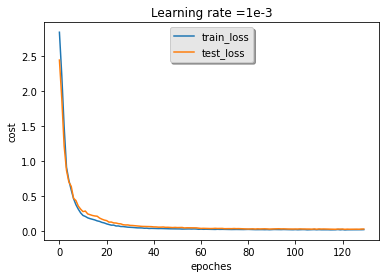

In [30]:
costs_tr = np.squeeze(cost_train)
costs_ts = np.squeeze(cost_validation)
# simi = np.squeeze(similarity_score)
plt.plot(costs_tr, label= 'train_loss')
plt.plot(costs_ts, label= 'test_loss')
# plt.plot(simi, label= 'similarity')
plt.ylabel('cost')
plt.xlabel('epoches')
plt.title("Learning rate =1e-3")
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

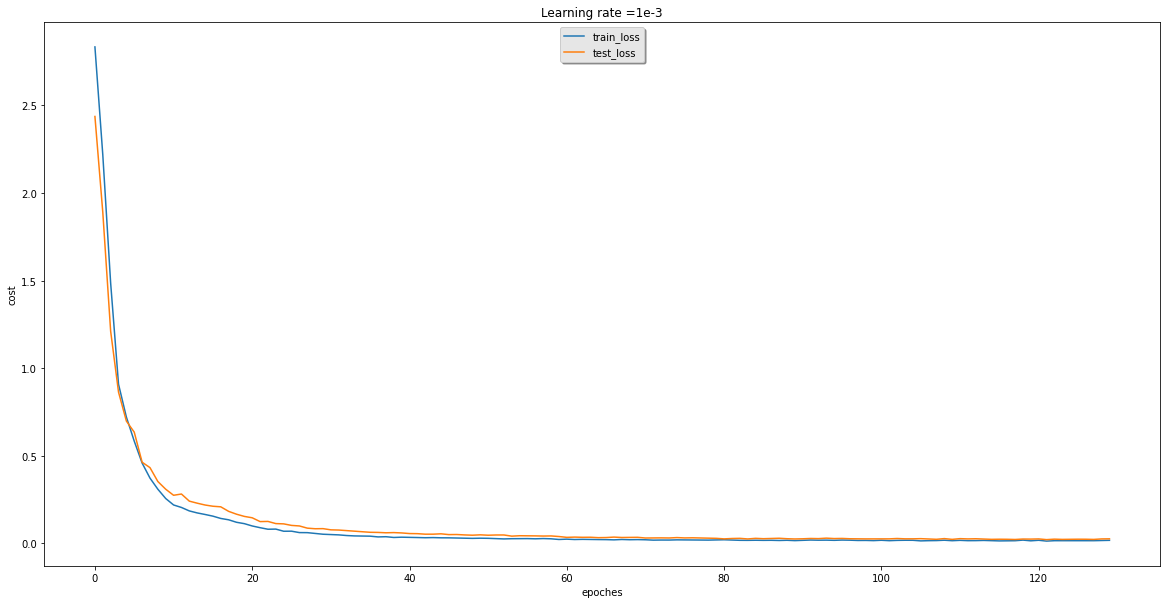

In [31]:
plt.figure(figsize=(20,10))
plt.plot(costs_tr, label= 'train_loss')
plt.plot(costs_ts, label= 'test_loss')
# plt.plot(simi, label= 'similarity')
plt.ylabel('cost')
plt.xlabel('epoches')
plt.title("Learning rate =1e-3")
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [32]:
# sm1 = np.squeeze(s1)
# sm2 = np.squeeze(s2)
# sm3 = np.squeeze(s3)
# sm4 = np.squeeze(s4)
# plt.plot(sm1, label= 'similarity1')
# plt.plot(sm2, label= 'similarity2')
# plt.plot(sm3, label= 'similarity3')
# plt.plot(sm4, label= 'similarity4')
# plt.ylabel('simlarity_value')
# plt.xlabel('epoches')
# plt.title("Learning rate =1e-3")
# legend2 = plt.legend(loc='upper center', shadow=True)
# frame = legend2.get_frame()
# frame.set_facecolor('0.90')
# plt.show()

In [33]:
# torch.save(model.state_dict(), "./model_v1")
# print("Saved PyTorch Model State to model.pth")